In [36]:
import pandas as pd
import re
import itertools
import torch
import ast
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [37]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)


Using device: mps


In [38]:

# Define the correct file path (adjust if needed)
file_path_final = "./resale_flat_prices_one_hot_vector_and_embed.xlsx"

# Load the Excel file
df_final = pd.read_excel(file_path_final)

# Drop missing values
df_final.dropna(inplace=True)

# Display first few rows
# df_final.head()

## Checking For Unique rows in dataset
"./resale_flat_prices_one_hot_vector_and_embed.xlsx"

In [39]:
# Flatten each row to a hashable tuple (handle list columns properly)
def row_to_tuple(row):
    flattened = []
    for val in row:
        if isinstance(val, list):
            flattened.extend(val)
        else:
            flattened.append(val)
    return tuple(flattened)

# Apply to each row
df_final['row_tuple'] = df_final.apply(row_to_tuple, axis=1)



'''
Example of row -> row_tuple transformation
row = {
     'month': '2017-01-01',
     'flat_type': '2 ROOM',
     'storey_category': 'Low',
     'floor_area_category': 40,
     'lease_commence_date': 1979.0,
     'remaining_lease': 61.33,
     'resale_price': 232000.0,
     'town_one_hot': [1, 0, 0, 0, 0],
     'flat_model_one_hot': [0, 0, 1],
     'hdb_classification_one_hot': [1, 0],
     'street_name_embed': [1.25, -0.25, 0.63]
 }

row_tuple=
 (
    '2017-01-01', '2 ROOM', 'Low', 40, 1979.0, 61.33, 232000.0,
     1, 0, 0, 0, 0,                     # town_one_hot
     0, 0, 1,                           # flat_model_one_hot
     1, 0,                              # hdb_classification_one_hot
     1.25, -0.25, 0.63                  # street_name_embed
 )

'''

# Count total and unique rows
total_rows = len(df_final)
unique_rows = df_final['row_tuple'].nunique()

print("Total rows:", total_rows)
print("Unique rows:", unique_rows)



Total rows: 391152
Unique rows: 391152


## Generate Static Vector

Static vectors are made from 
- 'town_one_hot', 
- 'flat_type',
- 'street_name_embed',
- 'storey_category', 
- 'floor_area_category', 
- 'flat_model_one_hot', 
- 'lease_commence_date',
- 'hdb_classification_one_hot' 

Row entries in this 'static vector' column can be thought of as a HDB flat profile

In [40]:

# Check data type for each static feature
static_features = [
    'town_one_hot', # str
    'flat_type', #str
    'street_name_embed', #str
    'storey_category', #str
    'floor_area_category', #numpy.int64
    'flat_model_one_hot', #str
    'lease_commence_date',#numpy.int64
    'hdb_classification_one_hot' #str
]

# for feature in static_features:
#   x=type(df_final.loc[0, feature])
#   print(feature,x)

# Convert numeric static features into python list
numeric_columns_to_fix = [
    'town_one_hot',
    'street_name_embed',
    'flat_model_one_hot',
    'hdb_classification_one_hot'
]

for col in numeric_columns_to_fix:
    df_final[col] = df_final[col].apply(ast.literal_eval)

# Convert non_numeric static features into one_hot_vectors
flat_type_mapping = {
    '1 ROOM': 0,
    '2 ROOM': 1,
    '3 ROOM': 2,
    '4 ROOM': 3,
    '5 ROOM': 4,
    'EXECUTIVE': 5,
    'MULTI-GENERATION': 6
}
storey_mapping = {
    'Low': 0,
    'High': 1
}
df_final['flat_type'] = df_final['flat_type'].map(flat_type_mapping)
df_final['storey_category'] = df_final['storey_category'].map(storey_mapping)


# Function to create static vector
def flatten_static_features(row):
    return torch.tensor(
        row['town_one_hot'] +
        row['flat_model_one_hot'] +
        row['hdb_classification_one_hot'] +
        row['street_name_embed'] +
        [
            row['lease_commence_date'],
            row['floor_area_category'],
            row['flat_type'],
            row['storey_category']
        ],
        dtype=torch.float32
    )

# Apply flatten_static_features function to every row in df_final
df_final['static_vector'] = df_final.apply(flatten_static_features, axis=1)

input_dim = len(df_final.loc[0, 'static_vector'])
print("Feedforward input dim:", input_dim)

# Sanity check: We now have column - static_vector - where every row is a 69 dimension tensor
df_final['static_vector']


Feedforward input dim: 69


0         [tensor(1.), tensor(0.), tensor(0.), tensor(0....
1         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
2         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
4         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
                                ...                        
391147    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391148    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391149    [tensor(0.), tensor(1.), tensor(0.), tensor(0....
391150    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391151    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
Name: static_vector, Length: 391152, dtype: object

# Checking for unique static vectors 

Problem - Collapsing too many rows into a single static vector could result in static vectors with a short sequence length. Ideally, we'd want a sequence length of at least 12 months

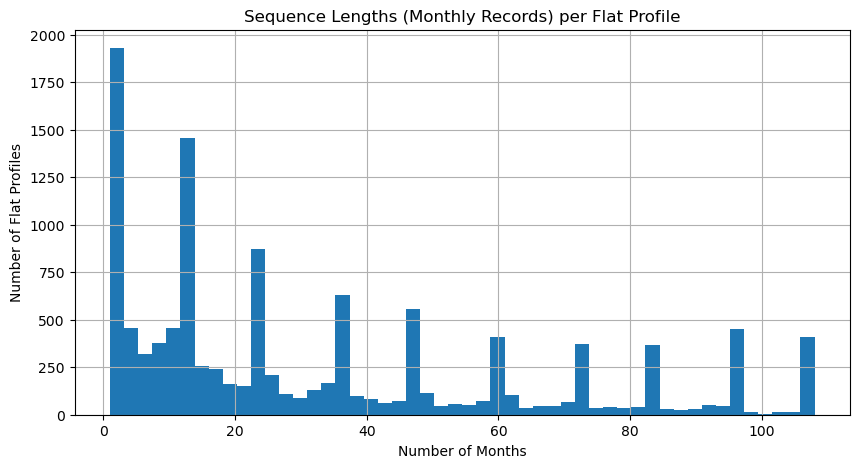

In [41]:

df_final['static_tuple'] = df_final['static_vector'].apply(lambda x: tuple(x.tolist()))
profile_sequence_lengths = df_final['static_tuple'].value_counts()
plt.figure(figsize=(10, 5))
profile_sequence_lengths.hist(bins=50)
plt.title("Sequence Lengths (Monthly Records) per Flat Profile")
plt.xlabel("Number of Months")
plt.ylabel("Number of Flat Profiles")
plt.grid(True)
plt.show()

In [42]:
num_profiles_gt_12 = (profile_sequence_lengths > 12).sum()
num_profiles_lt_12 = (profile_sequence_lengths < 12).sum()
avg_length = profile_sequence_lengths[profile_sequence_lengths > 12].mean()
num_unique_static_vectors = df_final['static_tuple'].nunique()

print("Number of unique static profiles", num_unique_static_vectors)
print("Number of static profiles with > 12 months of data:", num_profiles_gt_12)
print("Average sequence length (for profiles >12 months):", avg_length)
print("Number of static profiles with < 12 months of data:", num_profiles_lt_12)
print("Total Number of Rows in dataset",len(df_final))


Number of unique static profiles 11897
Number of static profiles with > 12 months of data: 7110
Average sequence length (for profiles >12 months): 50.75977496483826
Number of static profiles with < 12 months of data: 3537
Total Number of Rows in dataset 391152


## Clean up 
Filtering out unique static vectors with <12 months of data

In [43]:
valid_profiles = profile_sequence_lengths[profile_sequence_lengths > 12].index
df_filtered = df_final[df_final['static_tuple'].isin(valid_profiles)]
print("Filtered dataset size:", len(df_filtered))


Filtered dataset size: 360902


## Contigious Check 

Now that we have identified our static vectors with more than 12 months of data, there is still 1 more check we should do. The sequence must be contiguous, meaning that the sequence should not be disjointed 

In [44]:
# Dictionary to track if each profile has 12+ *consecutive* months
valid_continuous_profiles = []

# Convert to datetime if not already
df_filtered['month'] = pd.to_datetime(df_filtered['month'])

# Group by static profile
grouped = df_filtered.groupby('static_tuple')

for static_key, group in grouped:
    months = group['month'].sort_values().reset_index(drop=True)

    # Convert to month difference from first month
    deltas = months.diff().dropna().dt.days

    # Count longest streak of monthly continuity (≤31 days between months)
    streak = 1
    max_streak = 1
    for gap in deltas:
        if gap <= 31:  # Allow 1-month gaps
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 1  # Reset streak if gap too large

    if max_streak >= 12:
        valid_continuous_profiles.append(static_key)



/var/folders/5x/zyxhwl456zgdlj_lrsfyy9qm0000gn/T/ipykernel_14801/2618642495.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['month'] = pd.to_datetime(df_filtered['month'])


In [45]:
df_strict = df_filtered[df_filtered['static_tuple'].isin(valid_continuous_profiles)]
print("Strictly valid profiles with ≥12 *consecutive* months:", len(valid_continuous_profiles))
print("Remaining rows:", len(df_strict))

Strictly valid profiles with ≥12 *consecutive* months: 5632
Remaining rows: 321699


In [46]:
# Update df_final to only include valid continuous profiles
df_final = df_strict.copy()
df_final.reset_index(drop=True, inplace=True)
print("Final dataset size:", len(df_final))

Final dataset size: 321699


## Define Train - Test - Val split



In [ ]:

''' 
    Split dataset by flat profile. So each group is a flat profile with multiple months of data.
    Then sort each group by month to process the data in true chronological order
    Split each group into train, val, and test sets
    - Train: Before COVID
    - Val: 0-1 year after COVID
    - Test: 1+ years after COVID
'''

# Ensure 'month' column is datetime
df_final['month'] = pd.to_datetime(df_final['month'])

# Define COVID cutoff points
covid_start = pd.to_datetime("2020-01-01")
val_cutoff = pd.to_datetime("2021-01-01")
test_cutoff = pd.to_datetime("2021-01-01")  # Not strictly needed, just for clarity

# Split globally across all static profiles
df_train = df_final[df_final['month'] < covid_start].reset_index(drop=True)
df_val = df_final[(df_final['month'] >= covid_start) & (df_final['month'] < val_cutoff)].reset_index(drop=True)
df_test = df_final[df_final['month'] >= test_cutoff].reset_index(drop=True)

# ✅ Final sanity check
print(f"Train size: {len(df_train)} (Pre-COVID)")
print(f"Validation size: {len(df_val)} (0–1 year post-COVID)")
print(f"Test size: {len(df_test)} (1+ years post-COVID)")


Train size: 106344 (Pre-COVID)
Validation size: 36588 (0–1 year post-COVID)
Test size: 178767 (1+ years post-COVID)


### Round 2: Filter out Non-Contiguous Static Variables

After we have split our dataset into train-val-test sets, we might run into another round of non-contiguous data. Hence, we must filter them out again

In [51]:
def get_valid_continuous_profiles(df, min_streak=12):
    df['month'] = pd.to_datetime(df['month'])
    grouped = df.groupby('static_tuple')
    valid_profiles = []

    for static_key, group in grouped:
        months = group['month'].sort_values().reset_index(drop=True)
        deltas = months.diff().dropna().dt.days

        streak = 1
        max_streak = 1
        for gap in deltas:
            if gap <= 31:  # ≤1 month gap
                streak += 1
                max_streak = max(max_streak, streak)
            else:
                streak = 1
        if max_streak >= min_streak:
            valid_profiles.append(static_key)

    return valid_profiles


### Generate train-val-test files

In [52]:
# Filter train
train_valid_profiles = get_valid_continuous_profiles(df_train)
df_train = df_train[df_train['static_tuple'].isin(train_valid_profiles)].reset_index(drop=True)

# Filter val
val_valid_profiles = get_valid_continuous_profiles(df_val)
df_val = df_val[df_val['static_tuple'].isin(val_valid_profiles)].reset_index(drop=True)

# Filter test
test_valid_profiles = get_valid_continuous_profiles(df_test)
df_test = df_test[df_test['static_tuple'].isin(test_valid_profiles)].reset_index(drop=True)

print("Filtered train size:", len(df_train))
print("Filtered val size:", len(df_val))
print("Filtered test size:", len(df_test))

Filtered train size: 96662
Filtered val size: 30084
Filtered test size: 172737


## Save train, val and test dataframes

In [ ]:
# Save train, val, and test dataframes
# df_train.to_csv("train_data.csv", index=False)
# df_val.to_csv("val_data.csv", index=False)
# df_test.to_csv("test_data.csv", index=False)

## Create Feedforward layer using static vectors

In [53]:

# Define the feedforward model
class StaticFFModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(input_dim, 128), # The hidden layer here is also a tunable hyperparameter. I set 128 for now
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.ff(x)

# Create instance
static_ff = StaticFFModel(input_dim=69, output_dim=64) # Note we should modify the output dimension to fit the hidden layer of the LSTM model. I set 64 for now

# Move model to MPS (or CUDA/CPU depending on your setup)
static_ff = static_ff.to(device)

#processing df_train
static_tensor_batch = torch.stack(df_train['static_vector'].tolist()).to(device)  
feedforward_output_train = static_ff(static_tensor_batch)
df_train['static_embedding'] = feedforward_output_train.detach().cpu().tolist()

#processing df_val
static_tensor_batch = torch.stack(df_val['static_vector'].tolist()).to(device)
feedforward_output_val = static_ff(static_tensor_batch)
df_val['static_embedding'] = feedforward_output_val.detach().cpu().tolist()

#processing df_test
static_tensor_batch = torch.stack(df_test['static_vector'].tolist()).to(device)
feedforward_output_test = static_ff(static_tensor_batch)
df_test['static_embedding'] = feedforward_output_test.detach().cpu().tolist()

print ("Train set with static embedding shape:", df_train['static_embedding'].apply(lambda x: len(x)).unique())
print ("Val set with static embedding shape:", df_val['static_embedding'].apply(lambda x: len(x)).unique())
print ("Test set with static embedding shape:", df_test['static_embedding'].apply(lambda x: len(x)).unique())



Train set with static embedding shape: [64]
Val set with static embedding shape: [64]
Test set with static embedding shape: [64]


# Sliding Window

In [ ]:

class SlidingWindowDataset(Dataset):
    def __init__(self, df, window_size=12, non_static_cols=None, target_col='resale_price'):
        self.samples = []
        if non_static_cols is None:
            non_static_cols = ['resale_price', 'remaining_lease']

        grouped = df.groupby('static_tuple')

        for _, group in grouped:
            group = group.sort_values('month').reset_index(drop=True)
            static_embedding = torch.tensor(group.iloc[0]['static_embedding'], dtype=torch.float32)

            for i in range(len(group) - window_size):
                window = group.iloc[i:i + window_size]
                target_row = group.iloc[i + window_size]

                non_static_seq = torch.tensor(window[non_static_cols].values, dtype=torch.float32)
                target = torch.tensor(target_row[target_col], dtype=torch.float32)

                self.samples.append((non_static_seq, static_embedding, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]



class SlidingWindowDataLoader:
    def __init__(self, df, window_size=12, non_static_cols=None, target_col='resale_price', batch_size=32, shuffle=True):
        self.dataset = SlidingWindowDataset(
            df,
            window_size=window_size,
            non_static_cols=non_static_cols,
            target_col=target_col
        )
        self.dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=shuffle)

    def get_loader(self):
        return self.dataloader


# LSTM

In [ ]:
class LSTMEncoder(nn.Module):
    def __init__(self, non_static_dim, static_embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        input_dim = non_static_dim + static_embedding_dim
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_dim]
        out, (hn, cn) = self.lstm(x)
        return out  # or return hn[-1] for just the final hidden state
    
non_static_dim = 2   #[resale_price, remaining_lease]
static_embedding_dim = 64
hidden_dim = 128

lstm_encoder = LSTMEncoder(non_static_dim, static_embedding_dim, hidden_dim).to(device)

# Example
non_static_seq = torch.randn(batch_size, sequence_length, non_static_dim).to(device)
static_embed = torch.randn(batch_size, static_embedding_dim).to(device)

# Expand static embedding to match sequence length
static_seq = static_embed.unsqueeze(1).repeat(1, sequence_length, 1)  # [B, T, S]

# Concatenate
lstm_input = torch.cat([non_static_seq, static_seq], dim=-1)  # [B, T, N+S]

# Feed into encoder
lstm_output = lstm_encoder(lstm_input)

In [ ]:

def train_model(encoder, decoder, train_loader, val_loader, device, epochs=10, lr=1e-3):
    # Loss and optimizer
    loss_fn = nn.MSELoss()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        train_loss = 0

        for non_static_seq, static_embed, target in train_loader:
            non_static_seq = non_static_seq.to(device)
            static_embed = static_embed.to(device)
            target = target.to(device)

            sequence_length = non_static_seq.shape[1]

            # Concatenate static embedding at each time step
            static_seq = static_embed.unsqueeze(1).repeat(1, sequence_length, 1)
            lstm_input = torch.cat([non_static_seq, static_seq], dim=-1)

            # Forward
            output = encoder(lstm_input)                  # [B, T, hidden_dim]
            last_hidden = output[:, -1, :]                # [B, hidden_dim]
            prediction = decoder(last_hidden)             # [B]

            # Compute loss
            loss = loss_fn(prediction, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # ---------------------------
        # Validation
        encoder.eval()
        decoder.eval()
        val_loss = 0

        with torch.no_grad():
            for non_static_seq, static_embed, target in val_loader:
                non_static_seq = non_static_seq.to(device)
                static_embed = static_embed.to(device)
                target = target.to(device)

                sequence_length = non_static_seq.shape[1]
                static_seq = static_embed.unsqueeze(1).repeat(1, sequence_length, 1)
                lstm_input = torch.cat([non_static_seq, static_seq], dim=-1)

                output = encoder(lstm_input)
                last_hidden = output[:, -1, :]
                prediction = decoder(last_hidden)

                loss = loss_fn(prediction, target)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [ ]:

class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim=1):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x).squeeze(-1)  # [B]


In [ ]:
train_model(
    encoder=lstm_encoder,
    decoder=decoder,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=20,
    lr=1e-3
)

NameError: name 'decoder' is not defined